# Proyecto Final – **Estrategias de Trading Bull Call Spread para TSLA**

El presente trabajo tiene como objetivo aplicar los conocimientos de valuación de opciones y estrategias de trading para diseñar, justificar y analizar derivados financieros con base en datos reales.
La estrategia elegida es un ** Bull Call Spread ** sobre acciones de TSL, diseñada para aprovechar un movimiento moderadamente alcista del activo durante el próximo mes.

Tesla fue seleccionada por su alta liquidez en el mercado de opciones, su elevada volatilidad y su fuerte presencia en los mercados financieros internacionales. Estas características la convierten en un activo ideal para modelar estrategias con sensibilidad al precio y a la volatilidad.

---

### Justificación de la estrategia.
El Bull Call Spread consiste en comprar una opción call con un precio de ejercicio más bajo y vender otra call con un precio de ejercicio más alto, ambas con la misma fecha de vencimiento.
El objetivo es obtener una ganancia limitada si el activo sube moderadamente, mientras que la pérdida máxima se limita a la prima neta pagada.

Esta estrategia resulta adecuada cuando:

Se espera un movimiento alcista moderado del subyacente.

No se anticipa un aumento importante en la volatilidad.

Se busca reducir el costo inicial comparado con una simple compra de call.

---

Datos
| Variable                              |          Valor         |
| :------------------------------------ | :--------------------: |
| **Ticker**                            |          TSLA          |
| **Precio spot (S)**                   |         439.62         |
| **Tasa libre de riesgo (r)**          |         3.78 %         |
| **Volatilidad histórica (60 días)**   |         49.51 %        |
| **Volatilidad anualizada GARCH(1,1)** |         60.50 %        |
| **Fecha de vencimiento**              |    12 diciembre 2025   |
| **Tiempo a vencimiento (T)**          | 0.0822 años (~30 días) |

---

Modelo de volatilidad: GARCH (1,1)

Lo que nos dio de resultado fue que presenta una volatiilidad alta y persistente, ideal para estrategias de opciones con sensibilidad moderada al movimiento del precio.

---
Descripción del Bull Call Spread
| Tipo           | Strike (K) | Cantidad | Prima (mid) |   Delta |   Vega |  Theta |    Rho |
| :------------- | ---------: | -------: | ----------: | ------: | -----: | -----: | -----: |
| **Call larga** |        440 |       +1 |       26.70 | +0.5359 |  50.08 | -168.2 | +17.16 |
| **Call corta** |        445 |       -1 |       24.45 | -0.5061 | -50.27 | +168.5 | -16.26 |

Prima neta pagada: 2.25
Black-Scholes: 2.28

Con los Greeks netos podemos concluir que la posición tiene una exposición ligeramente alcista, Theta positivo y Vega negativa, lo que implica que una caída de la volatilidad beneficia la estrategia.

---
Simulación Monte Carlo
Se realizaron 100,00 simulaciones de precios bajo un proceso lognormal, utilizando la volatilidad y la tasa libre de riesgo.

| Métrica             |  Valor |
| :------------------ | -----: |
| Media (esperanza)   | +0.049 |
| Desviación estándar |  2.466 |
| Pérdida máxima      |  -2.25 |
| Ganancia máxima     |  +2.75 |

Distribución del P&L:

Alrededor del 52–55 % de los escenarios resultan en ganancia.

La pérdida está limitada y fija (-2.25).

La ganancia máxima se alcanza cuando el precio supera los 445 USD.

Conclusión general:

La estrategia es efectiva, coherente con los supuestos de mercado y permite controlar el riesgo mientras se aprovecha una visión alcista moderada.
Los modelos GARCH y Black-Scholes ofrecen resultados consistentes y muestran cómo el uso de herramientas cuantitativas mejora la toma de decisiones en estrategias con derivados.



## 1) Instalación y librerías

In [31]:
!pip install arch

In [32]:
# Si corres localmente y no tienes los paquetes, descomenta e instala:
# !pip install yfinance arch numpy pandas matplotlib scipy

import math, datetime as dt, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
import yfinance as yf

# (Opcional) Volatilidad condicional con GARCH
try:
    from arch import arch_model
    HAS_ARCH = True
except Exception:
    HAS_ARCH = False
    print("Paquete 'arch' no disponible. Se omitirá el GARCH (opcional).")

## 2) Configuración del experimento
- Puedes elegir **estrategia**: `"long_straddle"`, elige una expiración cercana a `~30` días.

In [33]:
# === Configuración ===
TICKER = "TSLA"                # Activo subyacente
STRATEGY = "bull_call_spread"     # "long_straddle" | "bull_call_spread" | "covered_call"
DTE_TARGET = 30                # días objetivo al vencimiento
HIST_WINDOW = 60               # ventana para volatilidad histórica (días)
RISK_FREE_FALLBACK = 0.045     # 4.5% anual si no hay tasa proxy
SEED = 123
N_PATHS = 100_000              # simulaciones Monte Carlo

np.set_printoptions(suppress=True, precision=6)
pd.options.display.float_format = "{:,.6f}".format

## 3) Teoría: Black–Scholes y **Greeks**
Funciones auxiliares para precios teóricos y sensibilidades.

In [34]:
def _d1_d2(S, K, T, r, sigma, q=0.0):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        raise ValueError("S, K, T, sigma deben ser positivos.")
    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return d1, d2

def bs_price(S, K, T, r, sigma, q=0.0, kind="call"):
    d1, d2 = _d1_d2(S, K, T, r, sigma, q)
    if kind.lower() == "call":
        return S*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*math.exp(-q*T)*norm.cdf(-d1)

def greeks(S, K, T, r, sigma, q=0.0, kind="call"):
    d1, d2 = _d1_d2(S, K, T, r, sigma, q)
    delta_call = math.exp(-q*T)*norm.cdf(d1)
    delta_put  = -math.exp(-q*T)*norm.cdf(-d1)
    gamma = math.exp(-q*T)*norm.pdf(d1) / (S*sigma*math.sqrt(T))
    vega  = S*math.exp(-q*T)*norm.pdf(d1)*math.sqrt(T)
    theta_call = (-S*math.exp(-q*T)*norm.pdf(d1)*sigma/(2*math.sqrt(T))
                  - r*K*math.exp(-r*T)*norm.cdf(d2)
                  + q*S*math.exp(-q*T)*norm.cdf(d1))
    theta_put  = (-S*math.exp(-q*T)*norm.pdf(d1)*sigma/(2*math.sqrt(T))
                  + r*K*math.exp(-r*T)*norm.cdf(-d2)
                  - q*S*math.exp(-q*T)*norm.cdf(-d1))
    rho_call = K*T*math.exp(-r*T)*norm.cdf(d2)
    rho_put  = -K*T*math.exp(-r*T)*norm.cdf(-d2)
    return ({"delta": delta_call, "gamma": gamma, "theta": theta_call, "vega": vega, "rho": rho_call}
            if kind.lower()=="call" else
            {"delta": delta_put, "gamma": gamma, "theta": theta_put, "vega": vega, "rho": rho_put})

## 4) Datos de mercado, volatilidad histórica y tasa libre de riesgo
- Descargamos precios con **yfinance**.
- Calculamos **volatilidad histórica** anualizada.
- Obtenemos una proxy de la tasa libre (**^IRX**, T-bill) o usamos un fallback.

In [35]:
def fetch_ts_data(ticker=TICKER, hist_window=HIST_WINDOW):
    tk = yf.Ticker(ticker)
    hist = tk.history(period="2y")["Close"]
    if hist.isna().all() or hist.empty:
        raise RuntimeError("No se obtuvo historia de precios. Revisa conexión o ticker.")
    spot = float(hist.iloc[-1])
    rets = np.log(hist/hist.shift(1)).dropna()
    hv = float(rets.tail(hist_window).std(ddof=1) * math.sqrt(252))  # anualizada
    return tk, hist, spot, hv

def try_fetch_risk_free():
    try:
        rf = yf.Ticker("^IRX").history(period="1mo")["Close"]
        if not rf.empty:
            return float(rf.iloc[-1])/100.0  # ^IRX viene en %
    except Exception:
        pass
    return RISK_FREE_FALLBACK

tk, hist, spot, hv = fetch_ts_data()
r = try_fetch_risk_free()

print(f"Spot {TICKER}: {spot:.4f}")
print(f"Volatilidad histórica {HIST_WINDOW}d (anual): {hv:.2%}")
print(f"Tasa libre (proxy): {r:.2%}")

Spot TSLA: 439.6200
Volatilidad histórica 60d (anual): 49.51%
Tasa libre (proxy): 3.78%


## 5) Selección de expiración cercana al objetivo de DTE
Tomamos la fecha de expiración disponible más cercana a `DTE_TARGET`.

In [36]:
def pick_expiration(tk, dte_target=DTE_TARGET):
    expirations = tk.options
    if not expirations:
        raise RuntimeError("No hay expiraciones listadas.")
    today = dt.date.today()
    candidates = []
    for e in expirations:
        d = dt.datetime.strptime(e, "%Y-%m-%d").date()
        dte = (d - today).days
        if dte > 1:
            candidates.append((e, abs(dte - dte_target), dte))
    if not candidates:
        e = expirations[0]
        dcal = (dt.datetime.strptime(e, "%Y-%m-%d").date() - today).days
        return e, dcal
    candidates.sort(key=lambda x: x[1])
    e = candidates[0][0]
    dcal = candidates[0][2]
    return e, dcal

expiration, dte = pick_expiration(tk, DTE_TARGET)
T = max(dte, 1)/365.0
print(f"Expiración elegida: {expiration} (~{dte} días) | T (años) = {T:.4f}")

Expiración elegida: 2025-12-12 (~30 días) | T (años) = 0.0822


## 6) Cadena de opciones e identificación de strikes relevantes
- Elegimos strikes **ATM** (cerca del spot) o predefinidos según la **estrategia**.

In [37]:
def fetch_option_chain(tk, expiration):
    chain = tk.option_chain(expiration)
    calls = chain.calls.copy()
    puts  = chain.puts.copy()
    for tbl in (calls, puts):
        tbl["mid"] = (tbl["bid"].fillna(0)+tbl["ask"].fillna(0))/2
        tbl["mid"] = tbl["mid"].replace(0, np.nan).fillna(tbl["lastPrice"])
    return calls, puts

def pick_atm(tbl, spot):
    tmp = tbl.dropna(subset=["strike"]).copy()
    tmp["dist"] = (tmp["strike"] - spot).abs()
    tmp.sort_values(["dist","openInterest","volume"], ascending=[True, False, False], inplace=True)
    return tmp.iloc[0].to_dict()

calls, puts = fetch_option_chain(tk, expiration)
opt_call = pick_atm(calls, spot)
opt_put  = pick_atm(puts,  spot)

Kc = float(opt_call["strike"])
Kp = float(opt_put["strike"])

ivc = float(opt_call["impliedVolatility"]) if not math.isnan(opt_call["impliedVolatility"]) else hv
ivp = float(opt_put["impliedVolatility"])  if not math.isnan(opt_put["impliedVolatility"])  else hv

mid_call = float(opt_call["mid"]); mid_put = float(opt_put["mid"])

print("ATM call:", opt_call["contractSymbol"], "Kc=", Kc, "IVc=", f"{ivc:.2%}", "mid=", mid_call)
print("ATM put :", opt_put["contractSymbol"],  "Kp=", Kp, "IVp=", f"{ivp:.2%}", "mid=", mid_put)

ATM call: TSLA251212C00440000 Kc= 440.0 IVc= 52.63% mid= 26.700000000000003
ATM put : TSLA251212P00440000 Kp= 440.0 IVp= 49.74% mid= 25.450000000000003


## 7) Definición de **estrategias**
Elegimos automáticamente strikes para tres estrategias comunes.  
> Puedes **ajustar** manualmente `K1`, `K2`, etc., según tu criterio.

In [38]:
def choose_strikes_for_strategy(spot, calls, puts, strategy="long_straddle"):
    # Encuentra strikes prácticos: ATM y pasos alrededor
    unique_strikes = np.sort(np.unique(np.concatenate([calls["strike"].values, puts["strike"].values])))
    # Elige strikes cercanos
    K_atm = unique_strikes[(np.abs(unique_strikes - spot)).argmin()]
    # Busca escalones alrededor del ATM
    idx = np.where(unique_strikes == K_atm)[0][0]
    K_below = unique_strikes[max(idx-1, 0)]
    K_above = unique_strikes[min(idx+1, len(unique_strikes)-1)]

    if strategy == "long_straddle":
        return {"legs": [("call", K_atm, +1), ("put", K_atm, +1)]}

    if strategy == "bull_call_spread":
        # Compra call ATM, vende call un escalón arriba
        return {"legs": [("call", K_atm, +1), ("call", K_above, -1)]}

    if strategy == "covered_call":
        # Simula 1 acción long + 1 call short ATM
        return {"legs": [("stock", None, +1), ("call", K_atm, -1)]}

    raise ValueError("Estrategia no soportada. Usa: long_straddle | bull_call_spread | covered_call")

STRAT = choose_strikes_for_strategy(spot, calls, puts, STRATEGY)
STRAT

{'legs': [('call', np.float64(440.0), 1), ('call', np.float64(445.0), -1)]}

## 8) Precios teóricos (BS) vs mercado e **Greeks** por pierna y netos
- Sumamos valor de cada **leg** (signo = + long, − short).
- Usamos **IV de la cadena** si está disponible; si no, caemos en **HV**.

In [39]:
def option_row(tbl, kind, K):
    if kind == "call":
        row = tbl.loc[(tbl["strike"]==K)].copy()
    else:
        row = tbl.loc[(tbl["strike"]==K)].copy()
    if row.empty:
        return None
    return row.iloc[0].to_dict()

def bs_and_greeks_for_leg(S, T, r, kind, K, iv_guess):
    price = bs_price(S, K, T, r, iv_guess, 0.0, kind)
    g = greeks(S, K, T, r, iv_guess, 0.0, kind)
    return price, g

legs_detail = []
total_mid = 0.0
total_bs  = 0.0
greeks_total = {"delta":0, "gamma":0, "theta":0, "vega":0, "rho":0}

for (typ, K, qty) in STRAT["legs"]:
    if typ == "stock":
        legs_detail.append({"type":"stock", "K":None, "qty":qty, "mid":spot, "bs":spot, "delta":qty*1.0, "gamma":0.0, "theta":0.0, "vega":0.0, "rho":0.0})
        total_mid += qty*spot
        total_bs  += qty*spot
        greeks_total["delta"] += qty*1.0
        continue

    tbl = calls if typ=="call" else puts
    row = tbl.loc[(tbl["strike"]==K)].copy()
    if row.empty:
        raise RuntimeError(f"No se encontró strike {K} en {typ}.")
    row = row.iloc[0].to_dict()
    mid = float(row["mid"])
    iv  = float(row["impliedVolatility"]) if not math.isnan(row["impliedVolatility"]) else hv

    theo, g = bs_and_greeks_for_leg(spot, T, r, typ, K, iv)

    legs_detail.append({
        "type": typ, "K": float(K), "qty": int(qty), "mid": mid, "bs": theo,
        **{k: qty*g[k] for k in g}
    })

    total_mid += qty*mid
    total_bs  += qty*theo
    for k in greeks_total:
        if k in g:
            greeks_total[k] += qty*g[k]

legs_df = pd.DataFrame(legs_detail)
summary_prices = pd.DataFrame({
    "Métrica": ["Valor mercado (mid)", "Valor teórico (BS)"],
    "Total":   [total_mid, total_bs]
})

print("=== Piernas de la estrategia ===")
display(legs_df)

print("\n=== Valor total ===")
display(summary_prices)

print("\n=== Greeks netos (suma) ===")
display(pd.DataFrame(greeks_total, index=["Netos"]))

=== Piernas de la estrategia ===


,type,K,qty,mid,bs,delta,gamma,theta,vega,rho
0,call,440.000000,1,26.700000,26.906004,0.535987,0.005989,-168.235023,50.076037,17.155441
1,call,445.000000,-1,24.450000,24.622251,-0.506190,-0.006010,168.545946,-50.274692,-16.266492



=== Valor total ===


,Métrica,Total
0,Valor mercado (mid),2.250000
1,Valor teórico (BS),2.283753



=== Greeks netos (suma) ===


,delta,gamma,theta,vega,rho
Netos,0.029797,-0.000021,0.310924,-0.198655,0.888949


## 9) Simulación **Monte Carlo** del subyacente y P\&L al vencimiento
- Modelo GBM con drift = `r` y `sigma` = **IV promedio** de las piernas (si no hay IV, HV).  
- Calculamos P\&L de la **estrategia** (sumando payoffs de cada pierna − costo neto inicial).

In [40]:
def mc_ST(S0, T, r, sigma, n_paths=N_PATHS, seed=SEED):
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(n_paths)
    drift = (r - 0.5*sigma**2)*T
    ST = S0 * np.exp(drift + sigma*math.sqrt(T)*Z)
    return ST

def payoff_leg(ST, typ, K, qty, init_mid):
    if typ == "stock":
        return qty*(ST - spot)  # P&L de la acción (valor final - inicial)
    if typ == "call":
        return qty*(np.maximum(ST - K, 0.0) - init_mid)
    if typ == "put":
        return qty*(np.maximum(K - ST, 0.0) - init_mid)
    raise ValueError("Tipo de pierna desconocido.")

# Sigma para simulación: promedio de IVs disponibles, si no HV
iv_list = []
for (typ, K, qty) in STRAT["legs"]:
    if typ in ("call","put"):
        tbl = calls if typ=="call" else puts
        row = tbl.loc[tbl["strike"]==K].iloc[0]
        iv_row = row["impliedVolatility"]
        if not math.isnan(iv_row):
            iv_list.append(float(iv_row))
sigma_sim = float(np.mean(iv_list)) if iv_list else hv

ST = mc_ST(spot, T, r, sigma_sim, n_paths=N_PATHS, seed=SEED)

# Costo inicial: suma de mids con signo (compra +, venta -)
init_cost = 0.0
for (typ, K, qty) in STRAT["legs"]:
    if typ == "stock":
        init_cost += qty*spot
    else:
        tbl = calls if typ=="call" else puts
        row = tbl.loc[tbl["strike"]==K].iloc[0]
        init_cost += qty*float(row["mid"])

# P&L por path
pnl = np.zeros_like(ST)
for (typ, K, qty) in STRAT["legs"]:
    if typ == "stock":
        pnl += payoff_leg(ST, typ, K, qty, init_mid=spot)
    else:
        tbl = calls if typ=="call" else puts
        row = tbl.loc[tbl["strike"]==K].iloc[0]
        mid = float(row["mid"])
        pnl += payoff_leg(ST, typ, K, qty, init_mid=mid)

pnl_stats = pd.Series(pnl).describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
display(pd.DataFrame(pnl_stats, columns=["P&L"]).T)

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
P&L,"100,000.000000",0.049433,2.466874,-2.250000,-2.250000,-2.250000,-2.250000,-2.250000,-2.250000,2.750000,2.750000,2.750000,2.750000,2.750000


## 10) Gráficas
- **Payoff teórico al vencimiento** (sin valor temporal).  
- **Distribución simulada de P\&L** (Monte Carlo).

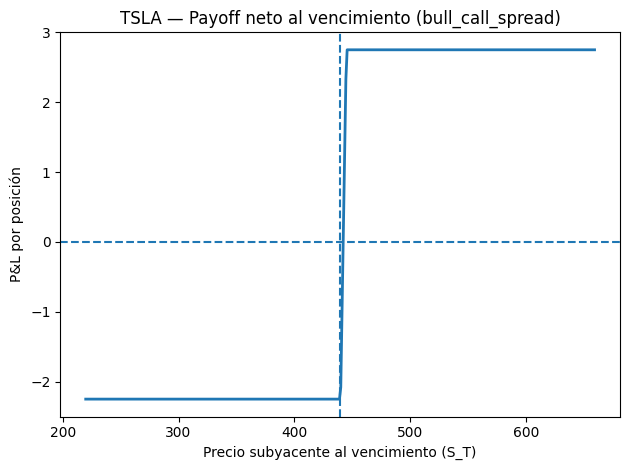

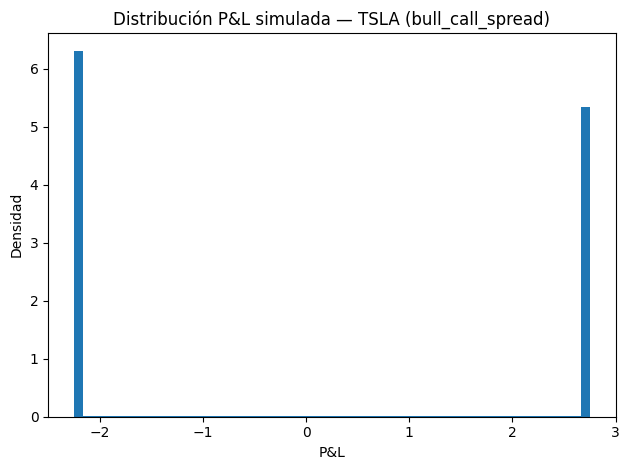

In [41]:
# Payoff al vencimiento sin valor temporal (usando precios de entrada mid para primas)
S_grid = np.linspace(spot*0.5, spot*1.5, 400)
payoff_curve = np.zeros_like(S_grid)
for (typ, K, qty) in STRAT["legs"]:
    if typ == "stock":
        payoff_curve += qty*(S_grid - spot)
    else:
        tbl = calls if typ=="call" else puts
        row = tbl.loc[tbl["strike"]==K].iloc[0]
        mid = float(row["mid"])
        if typ == "call":
            payoff_curve += qty*(np.maximum(S_grid - K, 0.0) - mid)
        else:
            payoff_curve += qty*(np.maximum(K - S_grid, 0.0) - mid)

plt.figure()
plt.plot(S_grid, payoff_curve, linewidth=2)
plt.title(f"{TICKER} — Payoff neto al vencimiento ({STRATEGY})")
plt.xlabel("Precio subyacente al vencimiento (S_T)")
plt.ylabel("P&L por posición")
plt.axhline(0, linestyle="--")
plt.axvline(spot, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(pnl, bins=60, density=True)
plt.title(f"Distribución P&L simulada — {TICKER} ({STRATEGY})")
plt.xlabel("P&L")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

## 11) (Opcional) Volatilidad **GARCH(1,1)** y comparación
Usa **ARCH** si está disponible para pronosticar volatilidad a corto plazo y cambiar `sigma_sim`.

In [42]:
if HAS_ARCH:
    print("Estimando GARCH(1,1) sobre retornos logarítmicos (%) ...")
    returns = 100 * np.log(hist/hist.shift(1)).dropna()
    am = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1, dist="Normal")
    res = am.fit(disp="off")
    print(res.summary())
    forecasts = res.forecast(horizon=5)
    pred_var = forecasts.variance.iloc[-1]
    pred_vol = np.sqrt(pred_var)
    vol_annual = float(pred_vol.iloc[-1]) * np.sqrt(252)
    print(f"Volatilidad anualizada GARCH (aprox): {vol_annual:.2f}")
else:
    print("GARCH no instalado: omitiendo esta sección.")

Estimando GARCH(1,1) sobre retornos logarítmicos (%) ...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -1387.64
Distribution:                  Normal   AIC:                           2781.29
Method:            Maximum Likelihood   BIC:                           2793.93
                                        No. Observations:                  500
Date:                Wed, Nov 12 2025   Df Residuals:                      500
Time:                        04:49:04   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------

## 12) Sensibilidades por escenario (what-if)
Variamos **σ** (volatilidad), **S** (spot) y **T** (tiempo) para observar cambios en el **valor teórico (BS)** de la estrategia.

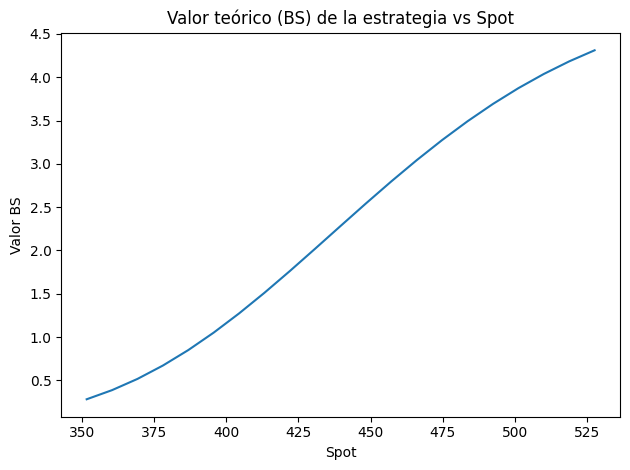

In [43]:
def bs_value_strategy(S, T, r, strategy, calls, puts):
    total = 0.0
    for (typ, K, qty) in strategy["legs"]:
        if typ == "stock":
            total += qty*S
        else:
            tbl = calls if typ=="call" else puts
            row = tbl.loc[tbl["strike"]==K].iloc[0]
            iv = float(row["impliedVolatility"]) if not math.isnan(row["impliedVolatility"]) else hv
            total += qty*bs_price(S, K, T, r, iv, 0.0, typ)
    return total

spots = np.linspace(spot*0.8, spot*1.2, 21)
values_at_spot = [bs_value_strategy(s, T, r, STRAT, calls, puts) for s in spots]

plt.figure()
plt.plot(spots, values_at_spot)
plt.title("Valor teórico (BS) de la estrategia vs Spot")
plt.xlabel("Spot")
plt.ylabel("Valor BS")
plt.tight_layout()
plt.show()

La curva muestra un aumento progresivo del valor del spread a medida que el precio del activo sube, estabilizándose después del strike superior (445).
Esto refleja el límite superior de ganancia impuesto por la call vendida.

In [44]:
print("=== TICKET DE OPERACIÓN (LONG STRADDLE TSLA) ===")
print(f"Subyacente: TSLA | Spot: {spot:.4f}")
print(f"Vencimiento: {expiration} (~{dte} días) | T = {T:.4f} años")
print("\nPiernas:")
print(f"  COMPRAR 1 CALL  K={Kc:.0f}  símbolo={opt_call['contractSymbol']}  prima(mid)=${mid_call:.3f}")
print(f"  COMPRAR 1 PUT   K={Kp:.0f}  símbolo={opt_put['contractSymbol']}   prima(mid)=${mid_put:.3f}")

total_premium = mid_call + mid_put
be_low  = Kc - total_premium
be_high = Kc + total_premium

print(f"\nPrima total pagada: ${total_premium:.3f} por set")
print(f"Break-evens:  {be_low:.3f}  y  {be_high:.3f}")
print("Pérdida máxima: prima total pagada (si S_T≈K)")


=== TICKET DE OPERACIÓN (LONG STRADDLE TSLA) ===
Subyacente: TSLA | Spot: 439.6200
Vencimiento: 2025-12-12 (~30 días) | T = 0.0822 años

Piernas:
  COMPRAR 1 CALL  K=440  símbolo=TSLA251212C00440000  prima(mid)=$26.700
  COMPRAR 1 PUT   K=440  símbolo=TSLA251212P00440000   prima(mid)=$25.450

Prima total pagada: $52.150 por set
Break-evens:  387.850  y  492.150
Pérdida máxima: prima total pagada (si S_T≈K)
